In [ ]:
# Mount Google Drive if needed
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
except:
    print("Not running in Colab or Drive already mounted")

# Install required packages if needed
try:
    import optuna
except:
    print("Installing Optuna...")
    !pip install optuna

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully


In [ ]:
# Regular Imports
import pandas as pd
import numpy as np
import time
import os
from tabulate import tabulate as tabulate_func
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# NLP Preprocessing Imports
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re

# HPO & Training imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import optuna

# Saving Files
import shutil
import glob
from typing import List, Optional

In [ ]:
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [ ]:
# Download NLTK data if needed
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
except:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Define base directories
RESULTS_DIR = "/content/drive/MyDrive/ADL Final Project/results"
LOGS_DIR = "/content/drive/MyDrive/ADL Final Project/logs"

# Load datasets
train_df = pd.read_csv("/content/drive/MyDrive/ADL Final Project/yelp_dataset_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/ADL Final Project/yelp_dataset_train.csv")

In [ ]:
# Sample 10% of the dataset for HPO
df_sampled, _ = train_test_split(train_df, test_size=0.90, stratify=train_df['class_index'], random_state=42)

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Get raw texts and labels
texts = df_sampled['review_text'].tolist()
labels = df_sampled['class_index'].tolist()

# Tokenize and pad/truncate to max_length=512
encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)

# Split the entire encoding dictionary
train_idx, val_idx = train_test_split(
    list(range(len(labels))), test_size=0.2, random_state=42, stratify=labels
)

# Now split each key in the encodings dictionary
train_encodings = {key: [val[i] for i in train_idx] for key, val in encodings.items()}
val_encodings = {key: [val[i] for i in val_idx] for key, val in encodings.items()}

# Split the labels using the indices
train_labels = [labels[i] for i in train_idx]
val_labels = [labels[i] for i in val_idx]

# Dataset class for Yelp reviews
class YelpDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the datasets
train_dataset = YelpDataset(train_encodings, train_labels)
val_dataset = YelpDataset(val_encodings, val_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def check_existing_trials():
    """Print information about existing trials and checkpoints"""
    if not os.path.exists(RESULTS_DIR):
        print(f"Results directory {RESULTS_DIR} does not exist.")
        return

    print("Existing trials:")
    for item in os.listdir(RESULTS_DIR):
        path = os.path.join(RESULTS_DIR, item)
        if os.path.isdir(path) and item.startswith("trial_"):
            print(f"- {item}")
            # Check for checkpoints
            if os.path.exists(path):
                checkpoints = [d for d in os.listdir(path) if d.startswith("checkpoint")]
                if checkpoints:
                    checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[-1]))
                    print(f"Checkpoints: {', '.join(checkpoints)}")
                else:
                    print("No checkpoints found")

def cleanup_trials(base_dir: str = RESULTS_DIR, logs_dir: str = LOGS_DIR, keep_last_n: int = 3, current_trial: Optional[int] = None):
    """
    Cleanup function to keep only the most recent n trials.

    Args:
        base_dir: Directory containing trial folders
        logs_dir: Directory containing log files
        keep_last_n: Number of most recent trials to keep
        current_trial: Current trial number (if known, to ensure it's kept)
    """
    print(f"Cleaning up trials, keeping only the last {keep_last_n}...")

    # Ensure the directories exist
    if not os.path.exists(base_dir):
        print(f"Results directory {base_dir} does not exist. Nothing to clean up.")
        return

    # Get all trial directories
    trial_dirs = []
    for item in os.listdir(base_dir):
        path = os.path.join(base_dir, item)
        if os.path.isdir(path) and item.startswith("trial_"):
            # Extract trial number
            match = re.search(r"trial_(\d+)", item)
            if match:
                trial_num = int(match.group(1))
                trial_dirs.append((trial_num, path))

    # Sort by trial number (ascending)
    trial_dirs.sort(key=lambda x: x[0])

    # If we have more than keep_last_n trials, delete the excess
    if len(trial_dirs) > keep_last_n:
        # Calculate how many to delete
        trials_to_delete = len(trial_dirs) - keep_last_n

        # Always exclude current trial if specified
        trials_to_keep = []
        if current_trial is not None:
            trials_to_keep.append(current_trial)

        # Go through trials (oldest first) and delete until we've removed enough
        deleted_count = 0
        for trial_num, trial_path in trial_dirs:
            # Skip if this is a trial we want to keep
            if trial_num in trials_to_keep:
                continue

            # Delete this trial
            print(f"Removing trial directory: {trial_path}")
            shutil.rmtree(trial_path)
            deleted_count += 1

            # Stop once we've deleted enough
            if deleted_count >= trials_to_delete:
                break

    # Clean up logs if the logs directory exists
    if os.path.exists(logs_dir):
        # Get remaining trial numbers to keep their logs
        remaining_trials = [trial_num for trial_num, _ in trial_dirs
                         if os.path.exists(os.path.join(base_dir, f"trial_{trial_num}"))]

        # Get all log files related to trials
        for item in os.listdir(logs_dir):
            path = os.path.join(logs_dir, item)
            if os.path.isfile(path):
                # Look for trial-specific logs
                match = re.search(r"trial_(\d+)", item)
                if match:
                    trial_num = int(match.group(1))
                    if trial_num not in remaining_trials and (current_trial is None or trial_num != current_trial):
                        print(f"Removing log file: {path}")
                        os.remove(path)

    # Print remaining trials
    remaining = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))
                and d.startswith("trial_")]
    print(f"Cleanup complete. Remaining trials: {sorted(remaining)}")

In [ ]:
def compute_metrics(pred):
    """Compute accuracy metrics for evaluation"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

def objective(trial):
    """Objective function for Optuna optimization"""
    start_time = time.time()

    # Hyperparameters to be tuned
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-3, log = True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log = True)
    lr_scheduler_type = trial.suggest_categorical('lr_scheduler_type', ['linear', 'cosine', 'polynomial'])

    # Prepare the model with 3 labels
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', num_labels=3
    ).to(device)

    # Set a unique output directory for this trial using the custom base path
    output_dir = f"{RESULTS_DIR}/trial_{trial.number}"

    # Define TrainingArguments with checkpoint saving every epoch
    training_args = TrainingArguments(
        output_dir = output_dir,                # unique output directory per trial
        num_train_epochs = 3,                   # each trial runs for 3 epochs
        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 64,
        warmup_steps = 500,
        weight_decay = weight_decay,
        logging_dir = LOGS_DIR,                 # updated logs directory
        logging_steps = 10,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",                # Save checkpoint at the end of each epoch
        load_best_model_at_end = True,
        metric_for_best_model = "accuracy",
        learning_rate = learning_rate,
        lr_scheduler_type = lr_scheduler_type,
        fp16 = True
    )

    # Check for an existing checkpoint in the output directory
    resume_checkpoint = None
    if os.path.isdir(output_dir):
        # Look for the latest checkpoint folder
        checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint")]
        if checkpoints:
            # Get the checkpoint with the largest step (or simply the last one)
            checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[-1]))
            resume_checkpoint = os.path.join(output_dir, checkpoints[-1])
            print(f"Resuming from checkpoint: {resume_checkpoint}")

    # Trainer setup
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train and evaluate, resuming if a checkpoint was found
    trainer.train(resume_from_checkpoint=resume_checkpoint)
    metrics = trainer.evaluate()

    elapsed_time = time.time() - start_time
    trial_info = {
        'trial_number': trial.number,
        'learning_rate': learning_rate,
        'weight_decay': weight_decay,
        'lr_scheduler_type': lr_scheduler_type,
        'eval_loss': metrics['eval_loss'],
        'eval_accuracy': metrics.get('eval_accuracy', None),
        'train_time': elapsed_time,
    }
    print(f"Trial {trial.number} - LR: {learning_rate} | WD: {weight_decay} | Scheduler: {lr_scheduler_type} | "
          f"Loss: {metrics['eval_loss']} | Accuracy: {metrics.get('eval_accuracy', 'N/A')} | Time: {elapsed_time:.2f}s")

    # Clean up old trials after this one completes
    cleanup_trials(current_trial=trial.number)

    return metrics['eval_loss']

def run_optuna_study(n_trials = 20):
    """
    Run the Optuna study with automatic cleanup after each trial
    """
    # Create the results and logs directories if they don't exist
    os.makedirs(RESULTS_DIR, exist_ok=True)
    os.makedirs(LOGS_DIR, exist_ok=True)

    # Create an Optuna study that minimizes eval_loss
    study_name = "distilbert_hpo"
    storage_name = f"sqlite:///{RESULTS_DIR}/{study_name}.db"

    # This is critical for resuming: always use load_if_exists=True
    study = optuna.create_study(
        direction="minimize",
        study_name=study_name,
        storage=storage_name,
        load_if_exists=True  # This ensures we load existing trials
    )

    print(f"Study loaded/created with {len(study.trials)} existing trials")

    # Print information about existing trials
    if study.trials:
        print("Existing trials summary:")
        for t in study.trials:
            if t.state == optuna.trial.TrialState.COMPLETE:
                print(f"Trial {t.number}: Loss={t.value}, Params={t.params}")

    # Run the optimization - this will resume from the last trial
    study.optimize(objective, n_trials=n_trials)

    # Final cleanup to ensure we only keep the last 3 trials
    cleanup_trials()

    print("Best trial:")
    trial = study.best_trial
    print(f"Value: {trial.value}")
    print("Params: ")
    for key, value in trial.params.items():
        print(f"{key}: {value}")

    return study

In [ ]:
# Command to start the training
if __name__ == "__main__":
    # Check existing trials first
    print("Checking existing trials and checkpoints:")
    check_existing_trials()

    # Make sure the optuna database exists or is in the correct location
    db_path = f"{RESULTS_DIR}/distilbert_hpo.db"
    if os.path.exists(db_path):
        print(f"Found Optuna database at {db_path}")
    else:
        print(f"Warning: Optuna database not found at {db_path}")

    # Run the optimization study (will resume from where it left off)
    study = run_optuna_study(n_trials = 20)

Checking existing trials and checkpoints:
Existing trials:
- trial_9
Checkpoints: checkpoint-2100, checkpoint-4200, checkpoint-6300
- trial_10
Checkpoints: checkpoint-2100, checkpoint-4200
Found Optuna database at /content/drive/MyDrive/ADL Final Project/results/distilbert_hpo.db


[I 2025-04-09 22:00:11,370] Using an existing study with name 'distilbert_hpo' instead of creating a new one.


Study loaded/created with 12 existing trials
Existing trials summary:
Trial 0: Loss=0.5206472277641296, Params={'learning_rate': 0.00011830953788815037, 'weight_decay': 1.6107295844778126e-06, 'lr_scheduler_type': 'polynomial'}
Trial 1: Loss=0.4647919535636902, Params={'learning_rate': 5.912234219476566e-05, 'weight_decay': 0.0002556353301134683, 'lr_scheduler_type': 'polynomial'}
Trial 2: Loss=0.3478752374649048, Params={'learning_rate': 9.574531145049087e-06, 'weight_decay': 1.0546886246647392e-06, 'lr_scheduler_type': 'polynomial'}
Trial 3: Loss=0.5017493367195129, Params={'learning_rate': 0.00028090525778322957, 'weight_decay': 8.03809504229523e-06, 'lr_scheduler_type': 'cosine'}
Trial 4: Loss=0.41416242718696594, Params={'learning_rate': 2.1661923386051955e-05, 'weight_decay': 5.778316023505699e-05, 'lr_scheduler_type': 'linear'}
Trial 5: Loss=0.43864676356315613, Params={'learning_rate': 4.8836807233118563e-05, 'weight_decay': 8.70199967992943e-06, 'lr_scheduler_type': 'cosine'}


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-1c77c78badc8>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using 

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: neel-1999 (neel-1999-humber-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.423900,0.386905,0.853333
2,0.275800,0.360138,0.861548
3,0.300700,0.354394,0.866667


[I 2025-04-09 22:24:38,675] Trial 12 finished with value: 0.35439392924308777 and parameters: {'learning_rate': 1.8967757927195973e-06, 'weight_decay': 6.762412545091342e-06, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.3478752374649048.


Trial 12 - LR: 1.8967757927195973e-06 | WD: 6.762412545091342e-06 | Scheduler: polynomial | Loss: 0.35439392924308777 | Accuracy: 0.8666666666666667 | Time: 1467.17s
Cleaning up trials, keeping only the last 3...
Cleanup complete. Remaining trials: ['trial_10', 'trial_12', 'trial_9']


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-1c77c78badc8>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.406300,0.376406,0.856905
2,0.250400,0.349313,0.867381
3,0.279100,0.346086,0.871190


[I 2025-04-09 22:49:05,851] Trial 13 finished with value: 0.34608596563339233 and parameters: {'learning_rate': 2.544772662255255e-06, 'weight_decay': 7.5913083231956945e-06, 'lr_scheduler_type': 'polynomial'}. Best is trial 13 with value: 0.34608596563339233.


Trial 13 - LR: 2.544772662255255e-06 | WD: 7.5913083231956945e-06 | Scheduler: polynomial | Loss: 0.34608596563339233 | Accuracy: 0.8711904761904762 | Time: 1467.05s
Cleaning up trials, keeping only the last 3...
Removing trial directory: /content/drive/MyDrive/ADL Final Project/results/trial_9
Cleanup complete. Remaining trials: ['trial_10', 'trial_12', 'trial_13']


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-1c77c78badc8>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.406100,0.369561,0.858452
2,0.237500,0.343555,0.870357
3,0.267400,0.341372,0.873452


[I 2025-04-09 23:13:17,043] Trial 14 finished with value: 0.34137189388275146 and parameters: {'learning_rate': 3.0236089332227517e-06, 'weight_decay': 3.4574243273578536e-06, 'lr_scheduler_type': 'polynomial'}. Best is trial 14 with value: 0.34137189388275146.


Trial 14 - LR: 3.0236089332227517e-06 | WD: 3.4574243273578536e-06 | Scheduler: polynomial | Loss: 0.34137189388275146 | Accuracy: 0.873452380952381 | Time: 1451.09s
Cleaning up trials, keeping only the last 3...
Removing trial directory: /content/drive/MyDrive/ADL Final Project/results/trial_10
Cleanup complete. Remaining trials: ['trial_12', 'trial_13', 'trial_14']


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-1c77c78badc8>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.412800,0.407107,0.845357
2,0.299200,0.373815,0.857738
3,0.316000,0.366839,0.860357


Trial 15 - LR: 1.4386005159796882e-06 | WD: 2.230917943528178e-05 | Scheduler: polynomial | Loss: 0.3668389618396759 | Accuracy: 0.8603571428571428 | Time: 1461.12s
Cleaning up trials, keeping only the last 3...
Removing trial directory: /content/drive/MyDrive/ADL Final Project/results/trial_12
Cleanup complete. Remaining trials: ['trial_13', 'trial_14', 'trial_15']


[I 2025-04-09 23:37:38,409] Trial 15 finished with value: 0.3668389618396759 and parameters: {'learning_rate': 1.4386005159796882e-06, 'weight_decay': 2.230917943528178e-05, 'lr_scheduler_type': 'polynomial'}. Best is trial 14 with value: 0.34137189388275146.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-1c77c78badc8>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.398900,0.348447,0.868690
2,0.204600,0.331646,0.877262
3,0.230000,0.332697,0.880119


Trial 16 - LR: 4.923530955993108e-06 | WD: 3.739824538545593e-06 | Scheduler: polynomial | Loss: 0.3326973617076874 | Accuracy: 0.8801190476190476 | Time: 1457.20s
Cleaning up trials, keeping only the last 3...
Removing trial directory: /content/drive/MyDrive/ADL Final Project/results/trial_13
Cleanup complete. Remaining trials: ['trial_14', 'trial_15', 'trial_16']


[I 2025-04-10 00:01:55,856] Trial 16 finished with value: 0.3326973617076874 and parameters: {'learning_rate': 4.923530955993108e-06, 'weight_decay': 3.739824538545593e-06, 'lr_scheduler_type': 'polynomial'}. Best is trial 16 with value: 0.3326973617076874.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-1c77c78badc8>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` in

Epoch,Training Loss,Validation Loss,Accuracy
1,0.394800,0.342472,0.870238
2,0.197300,0.329594,0.878690


Epoch,Training Loss,Validation Loss,Accuracy
1,0.394800,0.342472,0.870238
2,0.197300,0.329594,0.878690
3,0.219400,0.332118,0.881786


Trial 17 - LR: 5.6574024755645915e-06 | WD: 3.6325300277144817e-06 | Scheduler: linear | Loss: 0.33211827278137207 | Accuracy: 0.8817857142857143 | Time: 1465.56s
Cleaning up trials, keeping only the last 3...
Removing trial directory: /content/drive/MyDrive/ADL Final Project/results/trial_14


[I 2025-04-10 00:26:21,822] Trial 17 finished with value: 0.33211827278137207 and parameters: {'learning_rate': 5.6574024755645915e-06, 'weight_decay': 3.6325300277144817e-06, 'lr_scheduler_type': 'linear'}. Best is trial 17 with value: 0.33211827278137207.


Cleanup complete. Remaining trials: ['trial_15', 'trial_16', 'trial_17']


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-1c77c78badc8>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.390000,0.336652,0.873095
2,0.195400,0.326601,0.880952
3,0.208500,0.333164,0.882500


Trial 18 - LR: 6.4568163624853325e-06 | WD: 2.284750291963573e-05 | Scheduler: linear | Loss: 0.3331643044948578 | Accuracy: 0.8825 | Time: 1461.30s
Cleaning up trials, keeping only the last 3...
Removing trial directory: /content/drive/MyDrive/ADL Final Project/results/trial_15
Cleanup complete. Remaining trials: ['trial_16', 'trial_17', 'trial_18']


[I 2025-04-10 00:50:43,363] Trial 18 finished with value: 0.3331643044948578 and parameters: {'learning_rate': 6.4568163624853325e-06, 'weight_decay': 2.284750291963573e-05, 'lr_scheduler_type': 'linear'}. Best is trial 17 with value: 0.33211827278137207.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-1c77c78badc8>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` inst

Epoch,Training Loss,Validation Loss,Accuracy
1,0.377500,0.326921,0.875714
2,0.199600,0.323444,0.882976
3,0.184000,0.338978,0.884286


Trial 19 - LR: 8.115683943226106e-06 | WD: 0.0002472656103307324 | Scheduler: linear | Loss: 0.3389779031276703 | Accuracy: 0.8842857142857142 | Time: 1458.26s
Cleaning up trials, keeping only the last 3...
Removing trial directory: /content/drive/MyDrive/ADL Final Project/results/trial_16
Cleanup complete. Remaining trials: ['trial_17', 'trial_18', 'trial_19']


[I 2025-04-10 01:15:01,861] Trial 19 finished with value: 0.3389779031276703 and parameters: {'learning_rate': 8.115683943226106e-06, 'weight_decay': 0.0002472656103307324, 'lr_scheduler_type': 'linear'}. Best is trial 17 with value: 0.33211827278137207.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-1c77c78badc8>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` inste

Epoch,Training Loss,Validation Loss,Accuracy
1,0.347000,0.312038,0.881071
2,0.194400,0.319440,0.887976
3,0.123700,0.367023,0.887500


Trial 20 - LR: 1.336606944413412e-05 | WD: 2.5038567374664683e-05 | Scheduler: linear | Loss: 0.3194395899772644 | Accuracy: 0.8879761904761905 | Time: 1465.05s
Cleaning up trials, keeping only the last 3...
Removing trial directory: /content/drive/MyDrive/ADL Final Project/results/trial_17
Cleanup complete. Remaining trials: ['trial_18', 'trial_19', 'trial_20']


[I 2025-04-10 01:39:27,141] Trial 20 finished with value: 0.3194395899772644 and parameters: {'learning_rate': 1.336606944413412e-05, 'weight_decay': 2.5038567374664683e-05, 'lr_scheduler_type': 'linear'}. Best is trial 20 with value: 0.3194395899772644.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-1c77c78badc8>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` inste

Epoch,Training Loss,Validation Loss,Accuracy
1,0.338800,0.308341,0.882381
2,0.196000,0.321194,0.888452
3,0.117600,0.388306,0.889048


Trial 21 - LR: 1.6670154584589014e-05 | WD: 2.7105907463632337e-05 | Scheduler: linear | Loss: 0.38830599188804626 | Accuracy: 0.8890476190476191 | Time: 1463.15s
Cleaning up trials, keeping only the last 3...
Removing trial directory: /content/drive/MyDrive/ADL Final Project/results/trial_18
Cleanup complete. Remaining trials: ['trial_19', 'trial_20', 'trial_21']


[I 2025-04-10 02:03:50,576] Trial 21 finished with value: 0.38830599188804626 and parameters: {'learning_rate': 1.6670154584589014e-05, 'weight_decay': 2.7105907463632337e-05, 'lr_scheduler_type': 'linear'}. Best is trial 20 with value: 0.3194395899772644.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-1c77c78badc8>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` ins

Epoch,Training Loss,Validation Loss,Accuracy
1,0.422100,0.423398,0.841786


In [ ]:
# Define base directories
RESULTS_DIR = "/content/drive/MyDrive/ADL Final Project/results"
study_name = "distilbert_hpo"
storage_name = f"sqlite:///{RESULTS_DIR}/{study_name}.db"

In [ ]:
def get_optuna_study_details():
    """Extract all available details from the Optuna study database"""

    # Try to load the study
    try:
        study = optuna.load_study(study_name=study_name, storage=storage_name)
        print(f"Successfully loaded study '{study_name}' with {len(study.trials)} trials")
    except Exception as e:
        print(f"Error loading study: {e}")
        return

    # 1. Study Progress
    trial_states = {}
    for state in optuna.trial.TrialState:
        count = len([t for t in study.trials if t.state == state])
        if count > 0:
            trial_states[state.name] = count

    print("\n=== Study Progress ===")
    for state, count in trial_states.items():
        if state == optuna.trial.TrialState.COMPLETE:
            print(f"{state} trials: {count}")

    total_planned = 20  # From your original code
    completed = trial_states.get('COMPLETE', 0)
    print(f"Progress: {completed}/{total_planned} ({completed/total_planned:.1%})")

    # 2. Best Trial Information
    if completed > 0:
        best_trial = study.best_trial
        print("\n=== Best Trial ===")
        print(f"Trial #{best_trial.number}")
        print(f"Value (loss): {best_trial.value:.6f}")
        print("Parameters:")
        for key, value in best_trial.params.items():
            print(f"  {key}: {value}")

        if hasattr(best_trial, 'user_attrs') and best_trial.user_attrs:
            print("User Attributes:")
            for key, value in best_trial.user_attrs.items():
                print(f"  {key}: {value}")

    # 3. All Trials Summary
    print("\n=== All Trials Details ===")

    # Create a clean table with the available information
    headers = ["Trial #", "Status", "Value (Loss)", "Parameters", "Duration"]
    rows = []

    # For visualization
    plot_data = []

    # Filter to only include COMPLETE trials
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

    for trial in sorted(completed_trials, key=lambda t: t.number):
        # Basic info
        trial_num = trial.number
        status = trial.state.name
        value = f"{trial.value:.6f}" if trial.value is not None else "N/A"

        # Format parameters nicely
        params = ""
        if trial.params:
            param_parts = []
            for k, v in trial.params.items():
                if isinstance(v, float):
                    param_parts.append(f"{k}: {v:.2e}")
                else:
                    param_parts.append(f"{k}: {v}")
            params = ", ".join(param_parts)

        # Get duration if available
        duration = "N/A"
        if hasattr(trial, 'datetime_start') and trial.datetime_start:
            if hasattr(trial, 'datetime_complete') and trial.datetime_complete:
                duration = str(trial.datetime_complete - trial.datetime_start)

        # Add row to table
        rows.append([trial_num, status, value, params, duration])

        # Collect data for visualization (already filtered for COMPLETE status)
        plot_data.append({
            'trial': trial.number,
            'loss': trial.value,
            **trial.params
        })

    # Display the table
    from tabulate import tabulate
    print(f"Total completed trials: {len(completed_trials)}")
    print(tabulate(rows, headers=headers, tablefmt="grid"))

    # 4. Visualization if we have enough data
    if len(plot_data) >= 2:
        try:
            # Convert to DataFrame for plotting
            df = pd.DataFrame(plot_data)

            # Create plots
            plt.figure(figsize=(12, 8))

            # Plot 1: Trial progression
            plt.subplot(2, 2, 1)
            plt.plot(df['trial'], df['loss'], 'bo-')
            plt.title('Loss Progression by Trial')
            plt.xlabel('Trial Number')
            plt.ylabel('Loss Value')
            plt.grid(True)

            # Plot 2: Parameter importance
            if len(study.trials) >= 3:
                plt.subplot(2, 2, 2)
                try:
                    param_importances = optuna.importance.get_param_importances(study)
                    importance_df = pd.DataFrame({
                        'Parameter': list(param_importances.keys()),
                        'Importance': list(param_importances.values())
                    })
                    sns.barplot(x='Parameter', y='Importance', data=importance_df)
                    plt.title('Parameter Importance')
                    plt.xticks(rotation=45)
                except Exception as e:
                    plt.text(0.5, 0.5, f"Could not calculate parameter importance\n{str(e)}",
                             ha='center', va='center')

            # Plot 3: Learning rate vs Loss
            plt.subplot(2, 2, 3)
            if 'learning_rate' in df.columns:
                plt.scatter(df['learning_rate'], df['loss'])
                plt.xscale('log')
                plt.title('Learning Rate vs Loss')
                plt.xlabel('Learning Rate')
                plt.ylabel('Loss')
                plt.grid(True)

            # Plot 4: Weight decay vs Loss
            plt.subplot(2, 2, 4)
            if 'weight_decay' in df.columns:
                plt.scatter(df['weight_decay'], df['loss'])
                plt.xscale('log')
                plt.title('Weight Decay vs Loss')
                plt.xlabel('Weight Decay')
                plt.ylabel('Loss')
                plt.grid(True)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error creating visualizations: {e}")

    # 5. Distribution of hyperparameters
    if len(plot_data) >= 3:
        print("\n=== Hyperparameter Distribution ===")
        df = pd.DataFrame(plot_data)

        # Remove the non-parameter columns
        parameter_df = df.drop(['trial', 'loss'], axis=1, errors='ignore')

        # Print statistics for each parameter
        for param in parameter_df.columns:
            values = parameter_df[param].values
            if param in ['lr_scheduler_type']:  # Categorical params
                value_counts = parameter_df[param].value_counts().to_dict()
                print(f"{param}: {value_counts}")
            else:  # Numerical params
                print(f"{param}: min={min(values):.2e}, max={max(values):.2e}, mean={values.mean():.2e}")

    return study

Successfully loaded study 'distilbert_hpo' with 23 trials

=== Study Progress ===
Progress: 20/20 (100.0%)

=== Best Trial ===
Trial #20
Value (loss): 0.319440
Parameters:
  learning_rate: 1.336606944413412e-05
  weight_decay: 2.5038567374664683e-05
  lr_scheduler_type: linear

=== All Trials Details ===
Total completed trials: 20
+-----------+----------+----------------+--------------------------------------------------------------------------------+----------------+
|   Trial # | Status   |   Value (Loss) | Parameters                                                                     | Duration       |
+===========+==========+================+================================================================================+================+
|         0 | COMPLETE |       0.520647 | learning_rate: 1.18e-04, weight_decay: 1.61e-06, lr_scheduler_type: polynomial | 0:24:09.461306 |
+-----------+----------+----------------+------------------------------------------------------------------

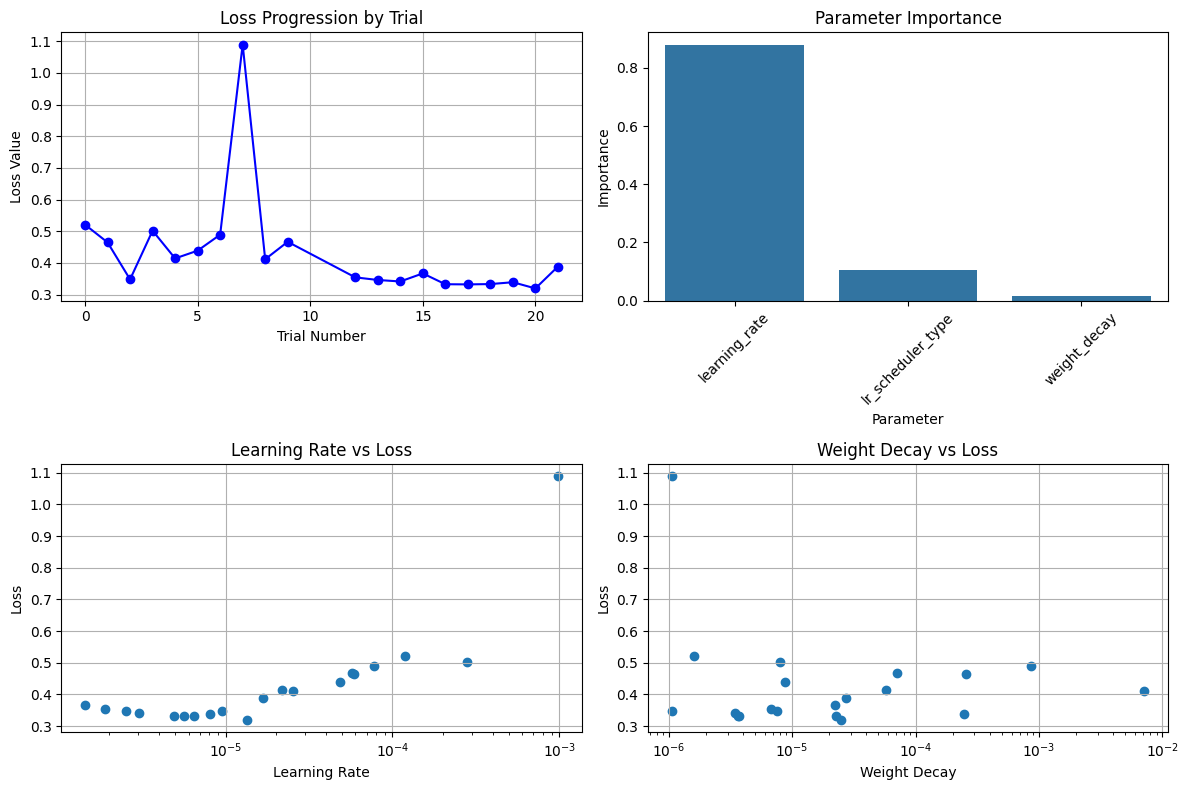


=== Hyperparameter Distribution ===
learning_rate: min=1.44e-06, max=9.82e-04, mean=8.73e-05
weight_decay: min=1.05e-06, max=7.16e-03, mean=4.40e-04
lr_scheduler_type: {'polynomial': 10, 'linear': 7, 'cosine': 3}


In [ ]:
# Run the analysis
if __name__ == "__main__":
    # Get the study details
    study = get_optuna_study_details()